In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_log_error,
    root_mean_squared_error
)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

sns.set(style='whitegrid')


In [2]:
# Загрузка данных и предобработка
df = pd.read_csv('dataset.csv')
print('Информация о датасете:')
df.info()
print('\nПропущенные значения по колонкам:')
print(df.isnull().sum())
# Заполняем пропуски нулями
df.fillna(0, inplace=True)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 1

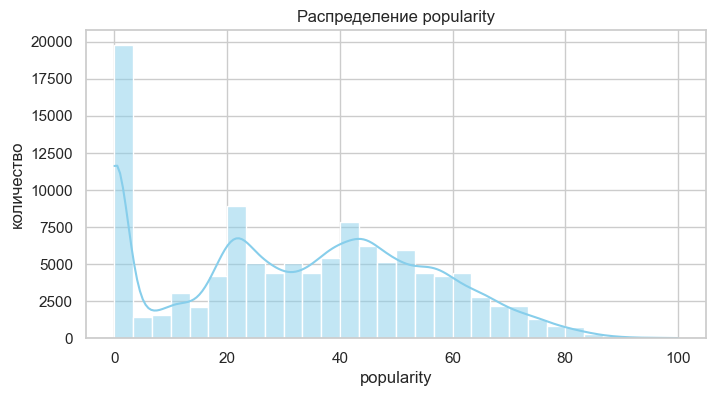

Вывод: распределение таргета показывает возможный сдвиг данных.


In [3]:
# Первичный анализ (EDA)
plt.figure(figsize=(8,4))
sns.histplot(df['popularity'], bins=30, kde=True, color='skyblue')
plt.title('Распределение popularity')
plt.xlabel('popularity')
plt.ylabel('количество')
plt.show()
print('Вывод: распределение таргета показывает возможный сдвиг данных.')

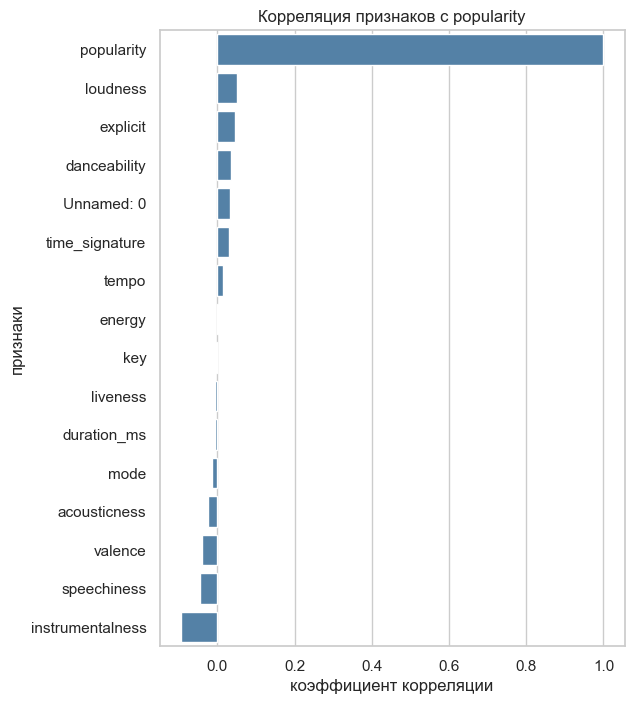

popularity          1.000000
loudness            0.050423
explicit            0.044082
danceability        0.035448
Unnamed: 0          0.032142
time_signature      0.031073
tempo               0.013205
energy              0.001056
key                -0.003853
liveness           -0.005387
duration_ms        -0.007101
mode               -0.013931
acousticness       -0.025472
valence            -0.040534
speechiness        -0.044927
instrumentalness   -0.095139
Name: popularity, dtype: float64 



In [4]:
# Корреляция признаков с таргетом
num_cols = df.select_dtypes(include=['int64','float64','bool']).columns
corr = df[num_cols].corr()
target_corr = corr['popularity'].sort_values(ascending=False)

plt.figure(figsize=(6,8))
sns.barplot(x=target_corr.values, y=target_corr.index, color='steelblue')
plt.title('Корреляция признаков с popularity')
plt.xlabel('коэффициент корреляции')
plt.ylabel('признаки')
plt.show()
print(target_corr, '\n')

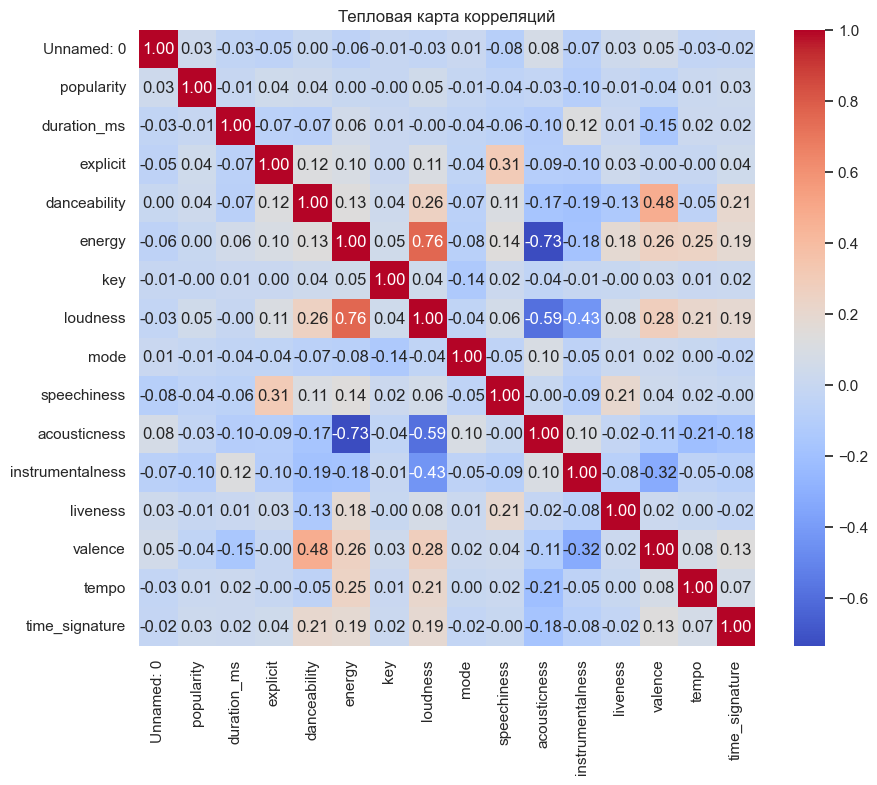

Вывод: тепловая карта показывает взаимосвязи между признаками.


In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Тепловая карта корреляций')
plt.show()
print('Вывод: тепловая карта показывает взаимосвязи между признаками.')

In [10]:
# Создание новых признаков
print('Добавляем дополнительные признаки:')
df['duration_min'] = df['duration_ms'] / 60000
if 'year' in df.columns:
    df['song_age'] = 2025 - df['year']
df['energy_dance'] = df['energy'] * df['danceability']
df['speech_instrument'] = df['speechiness'] * df['instrumentalness']
new_feats = [c for c in ['duration_min','song_age','energy_dance','speech_instrument'] if c in df.columns]
print(df[new_feats + ['popularity']].corr()['popularity'].sort_values(ascending=False))
print('Вывод: оценка влияния новых признаков на popularity.')

Добавляем дополнительные признаки:
popularity           1.000000
energy_dance         0.006060
duration_min        -0.007101
speech_instrument   -0.094479
Name: popularity, dtype: float64
Вывод: оценка влияния новых признаков на popularity.


In [11]:
# Подготовка данных и разбиение на train/test
features = [c for c in num_cols if c != 'popularity']
X = df[features]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Выборка разделена на обучающую и тестовую.')

Выборка разделена на обучающую и тестовую.


Оцениваем важность признаков (RandomForest):


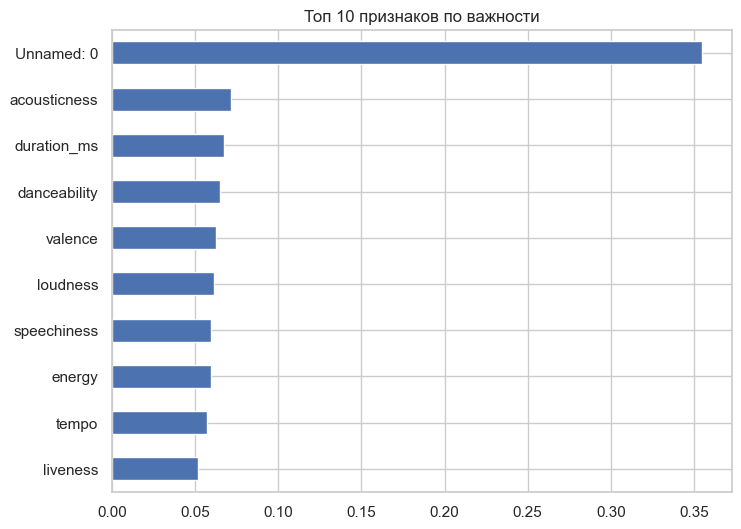

Unnamed: 0      0.354928
acousticness    0.071673
duration_ms     0.067719
danceability    0.065125
valence         0.062614
loudness        0.061591
speechiness     0.059585
energy          0.059344
tempo           0.056917
liveness        0.051584
dtype: float64
Вывод: ключевые признаки для модели.


In [12]:
# Важность признаков с RandomForest
print('Оцениваем важность признаков (RandomForest):')
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(10).plot(kind='barh')
plt.title('Топ 10 признаков по важности')
plt.gca().invert_yaxis()
plt.show()
print(importances.head(10))
print('Вывод: ключевые признаки для модели.')


Анализ зависимостей признаков с таргетом:


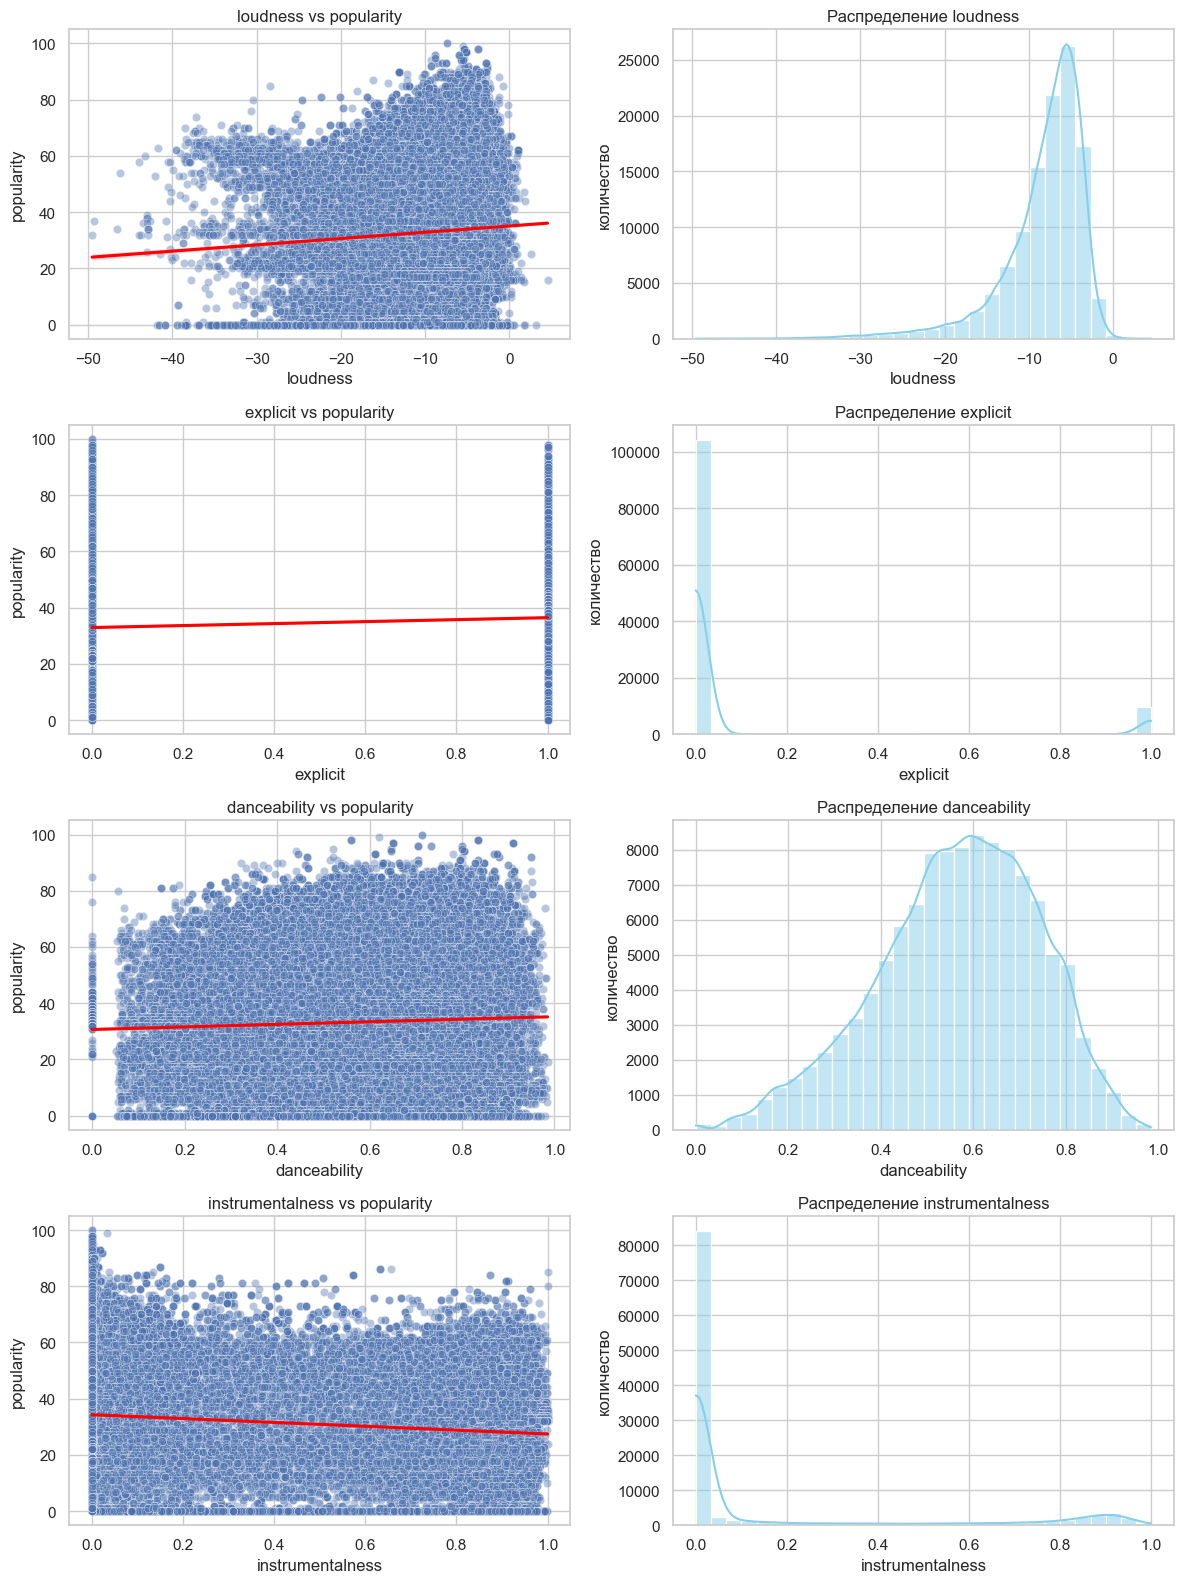

Вывод: визуальный анализ распределений и трендов.


In [13]:
# Визуализация зависимостей признаков
print('Анализ зависимостей признаков с таргетом:')
plot_feats = ['loudness','explicit','danceability','instrumentalness']
plt.figure(figsize=(12,16))
for i, feat in enumerate(plot_feats, 1):
    plt.subplot(4,2,2*i-1)
    sns.scatterplot(x=df[feat], y=y, alpha=0.4)
    sns.regplot(x=df[feat], y=y, scatter=False, color='red')
    plt.title(f'{feat} vs popularity')
    plt.xlabel(feat)
    plt.ylabel('popularity')
    plt.subplot(4,2,2*i)
    sns.histplot(df[feat], bins=30, kde=True, color='skyblue')
    plt.title(f'Распределение {feat}')
    plt.xlabel(feat)
    plt.ylabel('количество')
plt.tight_layout()
plt.show()
print('Вывод: визуальный анализ распределений и трендов.')

In [12]:
# Сравнение моделей (5-fold CV)
print('Сравниваем базовые модели посредством кросс-валидации:')
base_models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    'DecisionTree': Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeRegressor(random_state=42))]),
    'GradientBoosting': Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(random_state=42))]),
    'NeuralNetwork': Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42))])
}
results = []
for name, mdl in base_models.items():
    scores = cross_val_score(mdl, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    results.append({'Model': name, 'R2_mean': scores.mean(), 'R2_std': scores.std()})
    print(f"{name}: R2={scores.mean():.4f} ± {scores.std():.4f}")
results_df = pd.DataFrame(results).sort_values('R2_mean', ascending=False).reset_index(drop=True)
print(results_df)

Сравниваем базовые модели посредством кросс-валидации:
LinearRegression: R2=0.0258 ± 0.0006
DecisionTree: R2=0.0876 ± 0.0098
GradientBoosting: R2=0.2045 ± 0.0043
NeuralNetwork: R2=0.1554 ± 0.0056
              Model   R2_mean    R2_std
0  GradientBoosting  0.204507  0.004298
1     NeuralNetwork  0.155384  0.005632
2      DecisionTree  0.087631  0.009799
3  LinearRegression  0.025814  0.000611


In [13]:
# Сравнение моделей с полиномиальными признаками
print('Сравниваем модели на расширенном наборе признаков (топ 5 полиномиальных)')
top_feats = importances.head(5).index.tolist()
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_top = df[top_feats]
X_poly = poly.fit_transform(X_top)
poly_feats = poly.get_feature_names_out(top_feats)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feats)

Сравниваем модели на расширенном наборе признаков (топ 5 полиномиальных)


In [14]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

In [15]:
# Модели для сравнения
ext_models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    'GradientBoosting': Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(random_state=42))]),
    'RandomForest': Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])
}

In [16]:
# Сравниваем с уменьшенным CV и параллелизмом
results_p = []
for name, mdl in ext_models.items():
    scores = cross_val_score(mdl, X_train_p, y_train_p, cv=3, scoring='r2', n_jobs=-1)
    results_p.append({'Model': name, 'R2_mean': scores.mean(), 'R2_std': scores.std()})
    print(f"{name}: R2={scores.mean():.4f} ± {scores.std():.4f}")
results_p_df = pd.DataFrame(results_p).sort_values('R2_mean', ascending=False).reset_index(drop=True)
print(results_p_df)
print('Вывод: ускоренное сравнение моделей на полиномиальных признаках.')

LinearRegression: R2=0.0252 ± 0.0020
GradientBoosting: R2=0.2078 ± 0.0015
RandomForest: R2=0.4880 ± 0.0009
              Model   R2_mean    R2_std
0      RandomForest  0.488038  0.000949
1  GradientBoosting  0.207839  0.001530
2  LinearRegression  0.025240  0.001992
Вывод: ускоренное сравнение моделей на полиномиальных признаках.


Анализ эффективности MLPRegressor:
MLPRegressor: R2_mean=0.1562, R2_std=0.0060
MLPRegressor на тесте: R2_test=0.1654, RMSE=20.2942


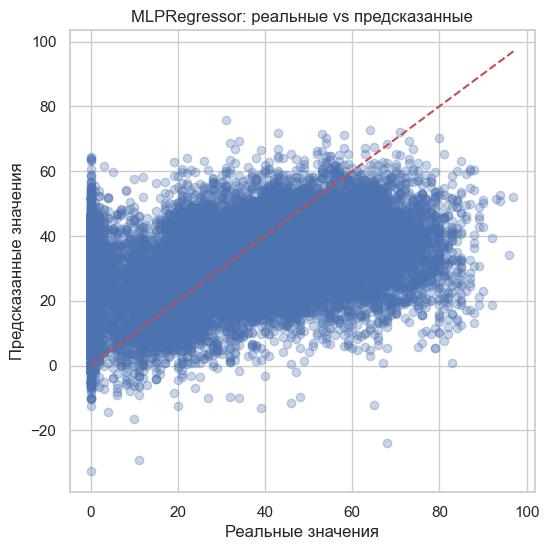

Вывод: оценка нейронной сети.


In [17]:
print('Анализ эффективности MLPRegressor:')
mlp_pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42))])
mlp_scores = cross_val_score(mlp_pipe, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"MLPRegressor: R2_mean={mlp_scores.mean():.4f}, R2_std={mlp_scores.std():.4f}")
mlp_pipe.fit(X_train, y_train)
pred_mlp = mlp_pipe.predict(X_test)
r2_mlp = r2_score(y_test, pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, pred_mlp))
print(f"MLPRegressor на тесте: R2_test={r2_mlp:.4f}, RMSE={rmse_mlp:.4f}")
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_mlp, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('MLPRegressor: реальные vs предсказанные')
plt.show()
print('Вывод: оценка нейронной сети.')

In [18]:
# Тюнинг гиперпараметров
print('Тюнинг гиперпараметров для RandomForest и GradientBoosting:')
from sklearn.model_selection import RandomizedSearchCV

# создаем словарь для сохранения лучших моделей
tuned_models = {}

# пайплайн для RandomForest и GradientBoosting
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])
pipe_gb = Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(random_state=42))])

# ограниченные сетки параметров
param_rf = {'rf__n_estimators': [50, 100, 150], 'rf__max_depth': [None, 5, 10]}
param_gb = {'gb__n_estimators': [50, 100, 150], 'gb__learning_rate': [0.01, 0.05, 0.1], 'gb__max_depth': [3, 5]}

rsearch_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_rf, n_iter=5, cv=3, scoring='r2', n_jobs=-1, random_state=42)
rsearch_rf.fit(X_train_p, y_train_p)
print(f"RF best params: {rsearch_rf.best_params_}, R2={rsearch_rf.best_score_:.4f}")
tuned_models['RandomForest'] = rsearch_rf.best_estimator_

rsearch_gb = RandomizedSearchCV(pipe_gb, param_distributions=param_gb, n_iter=5, cv=3, scoring='r2', n_jobs=-1, random_state=42)
rsearch_gb.fit(X_train_p, y_train_p)
print(f"GB best params: {rsearch_gb.best_params_}, R2={rsearch_gb.best_score_:.4f}")
tuned_models['GradientBoosting'] = rsearch_gb.best_estimator_

Тюнинг гиперпараметров для RandomForest и GradientBoosting:
RF best params: {'rf__n_estimators': 100, 'rf__max_depth': None}, R2=0.4880
GB best params: {'gb__n_estimators': 150, 'gb__max_depth': 3, 'gb__learning_rate': 0.05}, R2=0.1753


In [19]:
mlp_pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42))])
mlp_pipe.fit(X_train_p, y_train_p)
tuned_models['NeuralNetwork'] = mlp_pipe

In [20]:
# Создание и оценка ансамбля
ensemble = VotingRegressor(estimators=[
    ('rf', tuned_models['RandomForest']),
    ('gb', tuned_models['GradientBoosting']),
    ('nn', tuned_models['NeuralNetwork'])
])
scores_e = cross_val_score(ensemble, X_train_p, y_train_p, cv=5, scoring='r2', n_jobs=-1)
print(f"Ensemble R2={scores_e.mean():.4f} ± {scores_e.std():.4f}")
tuned_models['Ensemble'] = ensemble

Ensemble R2=0.3610 ± 0.0019


In [21]:
print('Итоговая оценка на тестовой выборке:')
final = []
for name, mdl in tuned_models.items():
    mdl.fit(X_train_p, y_train_p)
    pred = mdl.predict(X_test_p)
    r2 = r2_score(y_test_p, pred)
    rmse = np.sqrt(mean_squared_error(y_test_p, pred))
    final.append({'Model': name, 'R2_test': r2, 'RMSE': rmse})
    print(f"{name}: R2_test={r2:.4f}, RMSE={rmse:.4f}")

final_df = pd.DataFrame(final).sort_values('R2_test', ascending=False).reset_index(drop=True)
print(final_df)
print(f"Лучшая модель: {final_df.iloc[0]['Model']} с R2={final_df.iloc[0]['R2_test']:.4f}")

Итоговая оценка на тестовой выборке:
RandomForest: R2_test=0.5387, RMSE=15.0877
GradientBoosting: R2_test=0.1805, RMSE=20.1102
NeuralNetwork: R2_test=0.1539, RMSE=20.4335
Ensemble: R2_test=0.3784, RMSE=17.5136
              Model   R2_test       RMSE
0      RandomForest  0.538710  15.087663
1          Ensemble  0.378444  17.513599
2  GradientBoosting  0.180477  20.110173
3     NeuralNetwork  0.153916  20.433460
Лучшая модель: RandomForest с R2=0.5387


In [14]:
# Подготовка данных
X = df.drop(columns=['popularity', 'Unnamed: 0', 'track_id', 'track_name', 'artists', 'album_name', 'track_genre'])
y = df['popularity']

# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Метрики
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rmsle = mean_squared_log_error(y_test[y_test > 0], y_pred[y_test > 0]) ** 0.5

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSLE: {rmsle:.4f}')

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

print(f'Среднее значение R² по кросс-валидации: {cv_scores.mean():.4f}')
print(f'Стандартное отклонение R²: {cv_scores.std():.4f}')

R²: 0.5524
RMSE: 14.8614
MAE: 10.5299
MAPE: inf%
RMSLE: 0.5399
Среднее значение R² по кросс-валидации: 0.5482
Стандартное отклонение R²: 0.0046
